### ASTR 8070: Astrostatistics
***N. Pol***
___

# Homework 8
### Due: Friday, Apr 11th at 11.59pm CT
---

## Only one problem this week

1. Use the following code snippet to read in SDSS galaxy color data.

<!--```
from astroML.datasets import fetch_sdss_galaxy_colors
data = fetch_sdss_galaxy_colors()
```-->

`data = np.load('../hw_data/hw8_data_1.npy')`

This is a structured numpy array. Find and print all of the column names. Using the data, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. How many regular galaxies and how many quasars are in this sample?


2. Make a scatter plot of $(u-g)$ versus $(g-r)$, color coding by galaxy or quasar class. The plot should include appropriate axis labels and a legend. Set `xlim` between -0.5 and 2.5, and `ylim` between -0.5 and 1.5.


3. Stack all colors and the redshift into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing.


4. Create a compact `for` loop that iterates over the fitting of a Gaussian Naive Bayes classification algorithm to successively more features of the data. Within the loop, compute and plot an ROC curve. The end result should be a plot showing ROC curves for GNB classification with more and more features of the data, with appropriate axis labels and a legend. Use `xlim` between 0 and 0.01. Which feature seems to make the classification trivially easy? *Note: `predict_proba` returns an array with as many columns as classes. You've labeled quasars as $1$, so for the ROC curve you must make sure to access the relevant quasar probability-- you can find this by accessing the **classes_** attribute of the estimator.*


5. Repeat (4) for Quadratic Discriminant Analysis. 


6. Let's try classification with GMM Bayes. Restrict the training and testing to be just on the $4$ colors. Iterate now over number of components in the GMM Bayes fit up to $10$, plotting ROC curves for all, and find the number of components that gives the best performance.


7. Repeat (6) for $K$-nearest neighbor classification, looping over number of neighbors between 5 and 100 in steps of 10. Find the number that gives the best performance. 


8. Repeat (6) for Decision Tree classification, looping over the maximum tree depth between 1 and 10. Find the number that gives the best performance. 


9. Finally, plot the ROC curves for GNB, QDA, and the best-performing GMMBayes, KNN, and DT classification algorithms, all using just the 4 colors. What is the overall best-performing classifier? 


10. Make a 2-panel plot, showing in the left panel the color-coded training data in $(u-g)$ versus $(g-r)$ (similar to item 2 above), and in the right panel the same features of the testing data color coded by their predicted class from the tuned best-performing classifier. 

In [43]:
import numpy as np

data = np.load('./hw_data/hw8_data_1.npy')

print(data)
print(data.dtype.names)

[(19.46392, 18.89363, 18.85225, 18.8241 , 18.53599, 'QSO', 2.312959  , 1.925222e-04)
 (18.33262, 16.29118, 15.3018 , 14.81997, 14.45467, 'GALAXY', 0.05187586, 1.396275e-05)
 (18.85941, 17.01412, 15.97252, 15.51533, 15.11948, 'GALAXY', 0.09769295, 1.805014e-05)
 ...
 (18.76492, 18.12947, 18.04838, 17.94089, 17.677  , 'QSO', 2.267401  , 1.777254e-04)
 (19.36827, 19.06754, 18.9035 , 18.84508, 18.82694, 'QSO', 1.407278  , 8.702147e-04)
 (19.37275, 18.82985, 18.69858, 18.53639, 18.43456, 'QSO', 0.6865192 , 1.417279e-04)]
('u', 'g', 'r', 'i', 'z', 'specClass', 'redshift', 'redshift_err')


In [45]:
### variables
u, g, r, i, z = data['u'], data['g'], data['r'], data['i'], data['z']

ug = u - g
gr = g - r
ri = r - i
iz = i - z

spec_class = data['specClass']
redshift = data['redshift']
redshift_err = data['redshift_err']

n_galaxy = np.sum(spec_class == 'GALAXY')
n_qso = np.sum(spec_class == 'QSO')

print(f"Number of galaxies: {n_galaxy}")
print(f"Number of quasars: {n_qso}")

Number of galaxies: 42808
Number of quasars: 7192


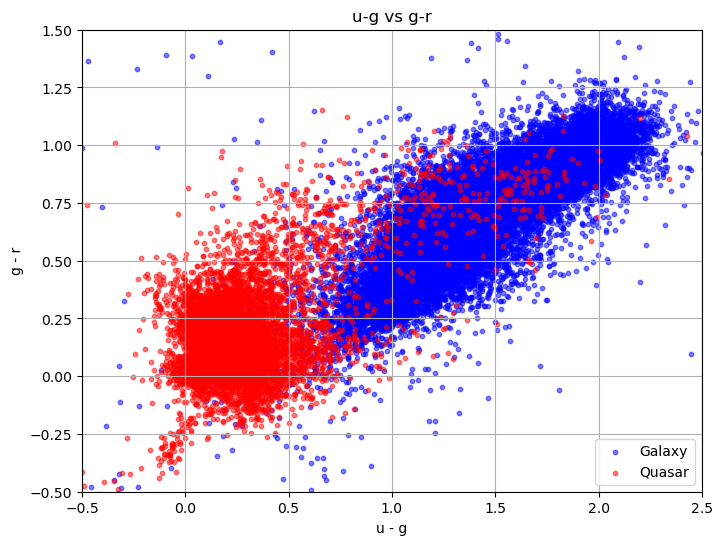

In [57]:
import matplotlib.pyplot as plt

colors = np.where(spec_class == 'GALAXY', 'blue', 'red')
labels = np.where(spec_class == 'GALAXY', 'Galaxy', 'Quasar')

plt.figure(figsize=(8, 6))
for ctype, color, label in [('GALAXY', 'blue', 'Galaxy'), ('QSO', 'red', 'Quasar')]:
    mask = spec_class == ctype
    plt.scatter(ug[mask], gr[mask], color=color, label=label, alpha=0.5, s=10)

plt.xlabel('u - g')
plt.ylabel('g - r')
plt.xlim(-0.5, 2.5)
plt.ylim(-0.5, 1.5)
plt.legend()
plt.title('u-g vs g-r')
plt.grid(True)
plt.show()


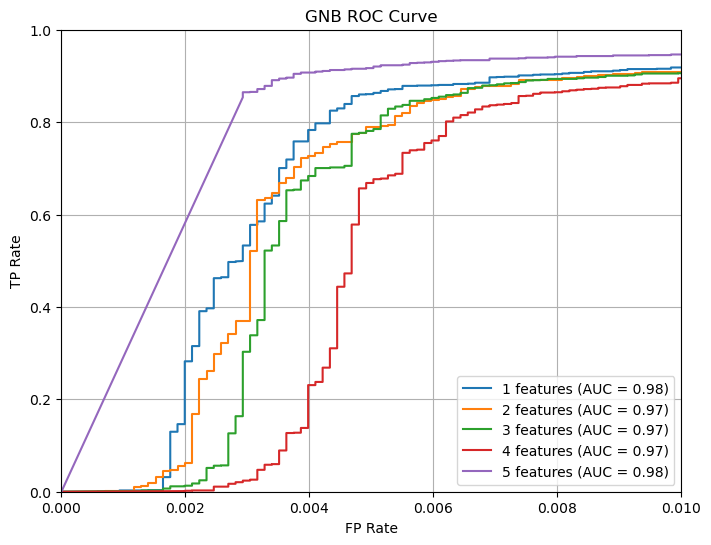

In [59]:
### imports
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc

### sklearn train and plots

X = np.vstack([ug, gr, ri, iz, redshift]).T # Feature matrix: stacking the 4 colors and redshift

y = (spec_class == 'QSO').astype(int) # Binary labels: 0 for galaxy, 1 for quasar

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Train-test split

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6))

for i in range(1, X_train.shape[1] + 1):
    gnb = GaussianNB()
    gnb.fit(X_train[:, :i], y_train)
    prob = gnb.predict_proba(X_test[:, :i])[:, list(gnb.classes_).index(1)]
    
    fpr, tpr, _ = roc_curve(y_test, prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{i} features (AUC = {roc_auc:.2f})')

plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title('GNB ROC Curve')
plt.legend()
plt.xlim(0, 0.01)
plt.ylim(0, 1.0)
plt.grid(True)
plt.show()


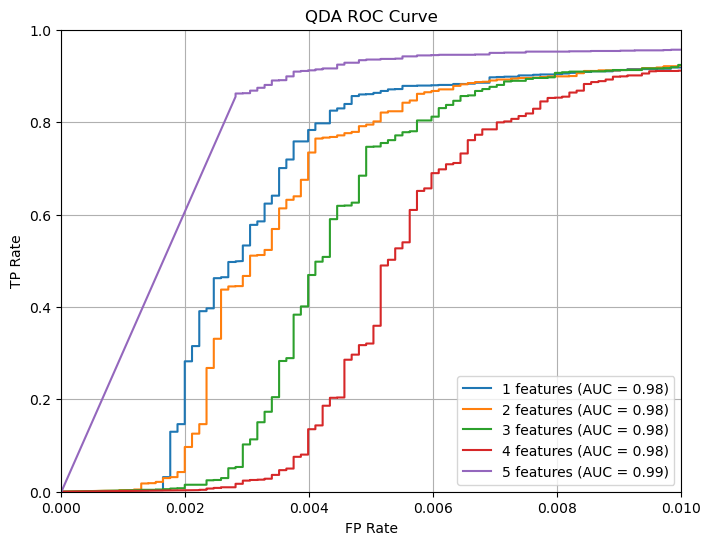

In [69]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

plt.figure(figsize=(8, 6))

for i in range(1, X_train.shape[1] + 1):
    qda = QDA()
    qda.fit(X_train[:, :i], y_train)
    prob = qda.predict_proba(X_test[:, :i])[:, list(qda.classes_).index(1)]
    
    fpr, tpr, _ = roc_curve(y_test, prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{i} features (AUC = {roc_auc:.2f})')

plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title('QDA ROC Curve')
plt.legend()
plt.xlim(0, 0.01)
plt.ylim(0, 1.0)
plt.grid(True)
plt.show()


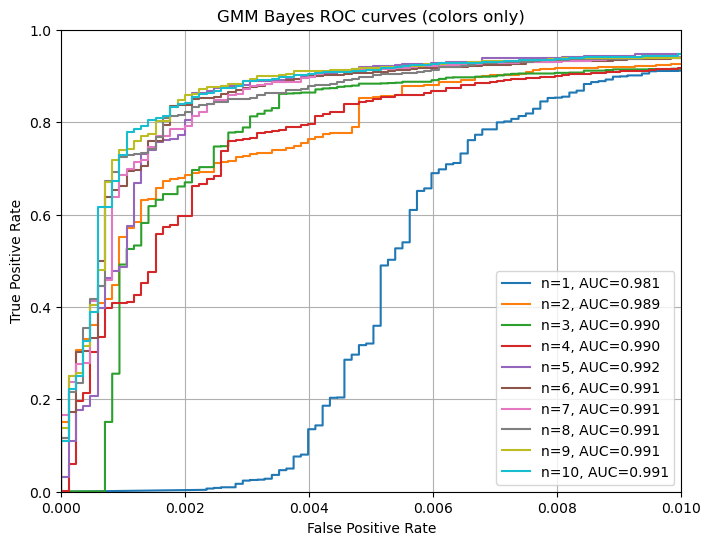

Best GMM performance: 0.992 with 5 components


In [79]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

### this cell is modified with GPT. it kept giving NaN related errors.

### variables
X_color = np.vstack([ug, gr, ri, iz]).T
y = (spec_class == 'QSO').astype(int)  # 0 = galaxy, 1 = quasar

mask = ~np.isnan(X_color).any(axis=1)
X_color_clean = X_color[mask]
y_clean = y[mask]

### Train-test split
from sklearn.model_selection import train_test_split
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_color_clean, y_clean, test_size=0.2, random_state=42)

plt.figure(figsize=(8, 6))
best_auc = 0
best_n = 0

for n_components in range(1, 11):
    gmm0 = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
    gmm1 = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)

    gmm0.fit(Xc_train[yc_train == 0])
    gmm1.fit(Xc_train[yc_train == 1])

    logprob0 = gmm0.score_samples(Xc_test)
    logprob1 = gmm1.score_samples(Xc_test)

    # Robust computation of probabilities (avoid divide-by-zero)
    logsum = np.logaddexp(logprob0, logprob1)
    prob = np.exp(logprob1 - logsum)

    # Filter out any remaining NaNs (just in case)
    valid = ~np.isnan(prob)
    fpr, tpr, _ = roc_curve(yc_test[valid], prob[valid])
    roc_auc = auc(fpr, tpr)

    if roc_auc > best_auc:
        best_auc = roc_auc
        best_n = n_components

    plt.plot(fpr, tpr, label=f'n={n_components}, AUC={roc_auc:.3f}')

plt.xlim(0, 0.01)
plt.ylim(0, 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('GMM Bayes ROC curves (colors only)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"Best GMM performance: {best_auc:.3f} with {best_n} components")


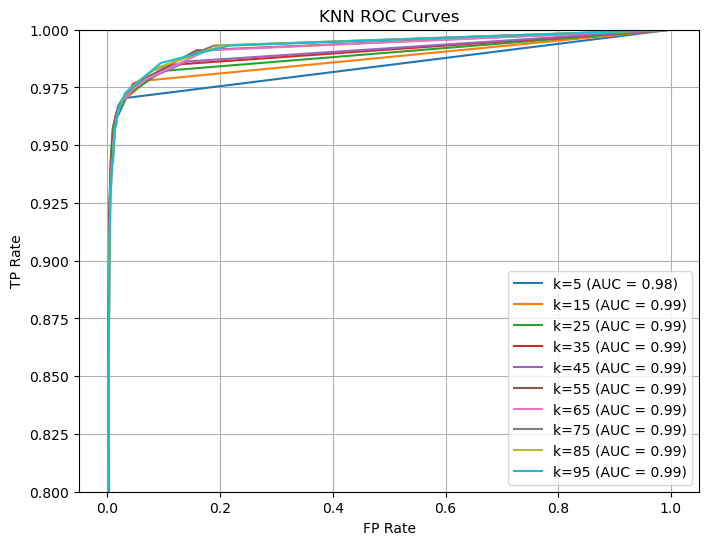

In [85]:
from sklearn.neighbors import KNeighborsClassifier

plt.figure(figsize=(8, 6))
best_auc_knn = 0
best_k_knn = None

for k in range(5, 101, 10):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(Xc_train, yc_train)
    prob = knn.predict_proba(Xc_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(yc_test, prob)
    roc_auc = auc(fpr, tpr)
    if roc_auc > best_auc_knn:
        best_auc_knn = roc_auc
        best_k_knn = k
        
    plt.plot(fpr, tpr, label=f'k={k} (AUC = {roc_auc:.2f})')

plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title('KNN ROC Curves')
plt.ylim(0.8, 1.0)
plt.legend()
plt.grid(True)


plt.show()


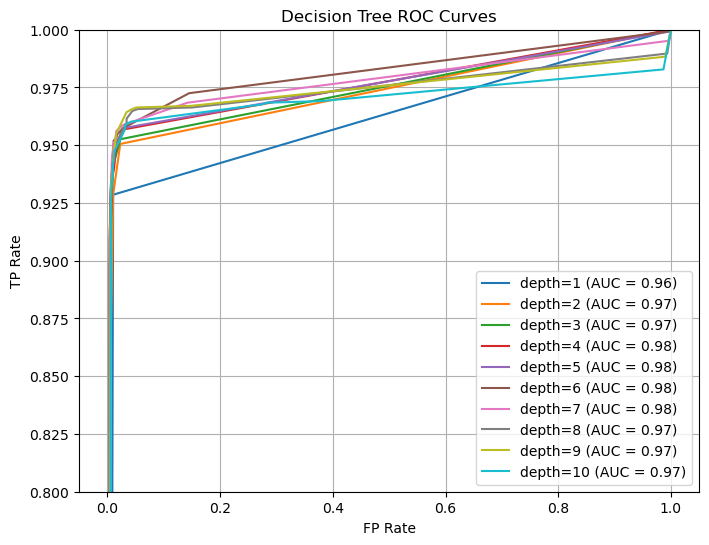

In [87]:
from sklearn.tree import DecisionTreeClassifier

plt.figure(figsize=(8, 6))
best_auc_dt = 0
best_depth = None

for d in range(1, 11):
    dt = DecisionTreeClassifier(max_depth=d, random_state=42)
    dt.fit(Xc_train, yc_train)
    prob = dt.predict_proba(Xc_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(yc_test, prob)
    roc_auc = auc(fpr, tpr)
    if roc_auc > best_auc_dt:
        best_auc_dt = roc_auc
        best_depth = d

    plt.plot(fpr, tpr, label=f'depth={d} (AUC = {roc_auc:.2f})')

plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title('Decision Tree ROC Curves')
plt.ylim(0.8, 1.0)
plt.legend()
plt.grid(True)
plt.show()


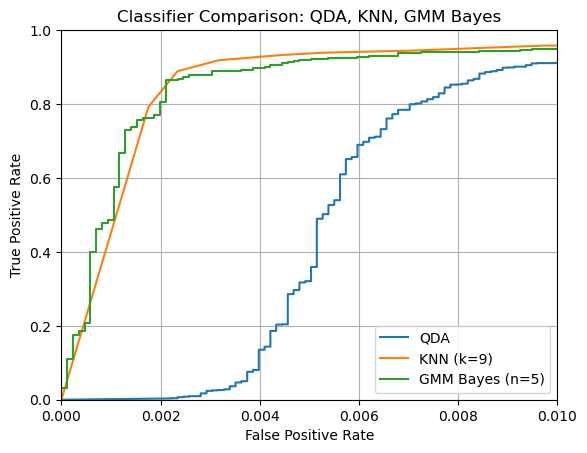

In [93]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# QDA
qda = QuadraticDiscriminantAnalysis()
qda.fit(Xc_train, yc_train)
prob_qda = qda.predict_proba(Xc_test)[:, 1]
fpr, tpr, _ = roc_curve(yc_test, prob_qda)
plt.plot(fpr, tpr, label='QDA')

# KNN
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(Xc_train, yc_train)
prob_knn = knn.predict_proba(Xc_test)[:, 1]
fpr, tpr, _ = roc_curve(yc_test, prob_knn)
plt.plot(fpr, tpr, label='KNN (k=9)')

# Best GMM Bayes
gmm0 = GaussianMixture(n_components=best_n, covariance_type='full', random_state=0).fit(Xc_train[yc_train == 0])
gmm1 = GaussianMixture(n_components=best_n, covariance_type='full', random_state=0).fit(Xc_train[yc_train == 1])

logprob0 = gmm0.score_samples(Xc_test)
logprob1 = gmm1.score_samples(Xc_test)
logsum = np.logaddexp(logprob0, logprob1)
prob_gmm = np.exp(logprob1 - logsum)

# Filter NaNs
valid = ~np.isnan(prob_gmm)
fpr, tpr, _ = roc_curve(yc_test[valid], prob_gmm[valid])
plt.plot(fpr, tpr, label=f'GMM Bayes (n={best_n})')

# Final plot setup
plt.xlim(0, 0.01)
plt.ylim(0, 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classifier Comparison: QDA, KNN, GMM Bayes')
plt.legend()
plt.grid(True)
plt.show()


### this cell is also modified with gpt. NaN problem again, along with some errors in each methods.

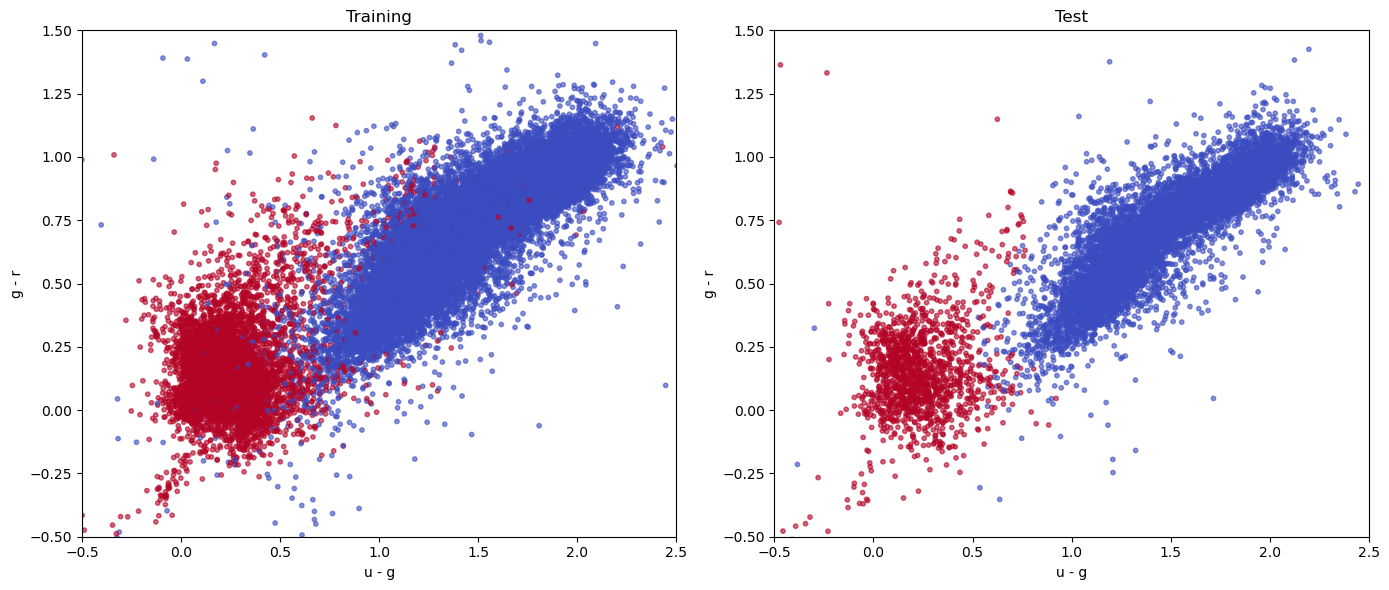

In [97]:
best_clf = KNeighborsClassifier(n_neighbors=best_k_knn).fit(Xc_train, yc_train)
y_pred = best_clf.predict(Xc_test)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

### Training
ax[0].scatter(Xc_train[:, 0], Xc_train[:, 1], c=yc_train, cmap='coolwarm', s=10, alpha=0.6)
ax[0].set_title('Training')
ax[0].set_xlabel('u - g')
ax[0].set_ylabel('g - r')
ax[0].set_xlim(-0.5, 2.5)
ax[0].set_ylim(-0.5, 1.5)

### Test
ax[1].scatter(Xc_test[:, 0], Xc_test[:, 1], c=y_pred, cmap='coolwarm', s=10, alpha=0.6)
ax[1].set_title('Test')
ax[1].set_xlabel('u - g')
ax[1].set_ylabel('g - r')
ax[1].set_xlim(-0.5, 2.5)
ax[1].set_ylim(-0.5, 1.5)

plt.tight_layout()
plt.show()


### I'm not sure what I am doing exactly, but I tried to do something similar to the lecture notes! :)

<span style="color:red">NP: missing labels on right-hand panel, where you had to show your predictions on the test data and compare to the training data. -1 pt</span>